# Tema 23: Tamaños del efecto
En esta libreta aprenderás cómo calcular algunos de los tamaños del efecto más utilizados, la d de Cohen, la g de Hedge, la r de Rosenthal y la correlación rango-biserial.

## Librerías

In [2]:
import numpy as np # para semilla aleatoria
import scipy.stats as stats
from scipy.special import expit, gamma
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42) # establece la semilla que quieras

print('Librerías importadas y semilla establecida')

Librerías importadas y semilla establecida



##  Datos
Para esta libreta utilizaremos datos simulados con una variable dicotómica de agrupación y una variable cuantitativa
La variable X será normal con media de 100 y desviación estándar de 15, emulando la distribución del cociente de desarrollo.
Y la variable dicotómica será simulada con base en la función expit (logit inversa) `grupo ~ X + error`.


El dataset simula una cohorte infantil con medición del cociente de desarrollo. El supuesto de la simulación es que el grupo de intervención tendrá un cociente de desarrollo mayor que el grupo control.


In [3]:
N = 100
X = stats.norm.rvs(100, 15, size=N).astype(int)
err = stats.norm.rvs(0, 3, size=N)
z = -100 + X + err
prob = expit(z)
grupo = stats.bernoulli.rvs(prob)

data = pd.DataFrame({
    'Grupo': grupo,
    'X': X 
})
data.head()


,Grupo,X
0,1,107
1,0,97
2,1,109
3,1,122
4,0,96


## Visualización de los datos
Visualicemos nuestros datos.

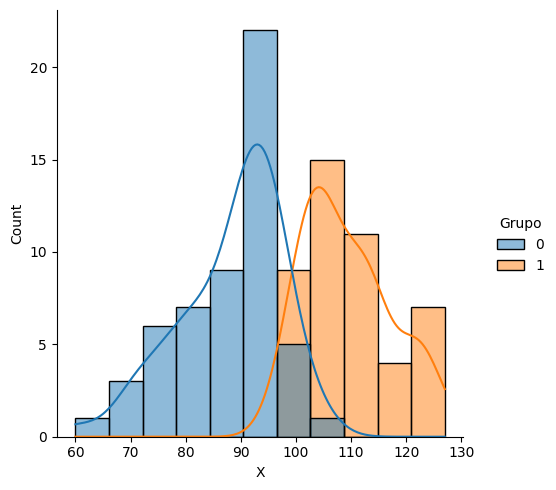

In [4]:
sns.displot(data, x='X', hue='Grupo', kde=True)


## Diferencia de grupos

Podemos ver que hay una diferencia a favor del grupo de estudio, ahora veamos si la diferencia es estadísticamente significativa, como el objetivo de la libreta es el tamaño del efecto, utilizaremos tanto la prueba T para grupos independientes como la prueba U de mann whitney y guardaremos los resultados.

Para mayor facilidad, separemos la puntuación de desarrollo para cada grupo.

In [5]:
control = data[data['Grupo'] == 0]['X']
intervencion = data[data['Grupo'] == 1]['X']

res_t = stats.ttest_ind(control, intervencion)
res_u = stats.mannwhitneyu(control, intervencion)

print(f'Resutado prueba T: p={res_t.pvalue:.3f}')
print(f'Resutado prueba U de Mann-Whitney: p={res_u.pvalue:.3f}')


Resutado prueba T: p=0.000
Resutado prueba U de Mann-Whitney: p=0.000


Con esto podemos ver que efectivamente la diferencia es estadísticamente significativa. Esto no debe sorprendernos puesto que así diseñamos el dataset, pero puedes modificar el código de la simulación para ver qué otros resultados podríamos tener.

:::{tip}
Puedes modificar la desviación estándar del error para disminuir la diferencia entre los sujetos en la variable X, ya que disminuimos el poder explicativo de la variable. O puedes utilizar un valor multiplicativo (coeficiente) menor a 1 en la ecuación.
:::

## d de Cohen
La d de Cohen se calcula, para muestras independientes como:

$$
\sigma_{pooled} = \sqrt{
    \frac{(n_1-1)*\sigma_1^2 + (n_2-1)*\sigma_2^2}{(n_1 + n_2 - 2)}
}
$$

$$d = \frac{\bar{x}_1 - \bar{x}_2}{\sigma_{pooled}}$$

Codifiquémoslo en una función que tome los datos de las dos variables. Aunque, no tengamos los valores de sigma, por lo que utilizaremos los estimadores de la muestra.

In [6]:
def pooled_s(a, b):
    n1, n2 = len(a), len(b)
    var1 = np.var(a, ddof=1) # n-1
    var2 = np.var(b, ddof=1) # n-1

    sp = np.sqrt(
        ((n1-1)*var1 + (n2-1)*var2) 
        /
        (n1+n2-2)
    )

    return sp

def d_cohen(a, b):
    """
    Calcula el tamaño del efecto d de Cohen para dos muestras independientes.

    El d de Cohen es una medida estandarizada de la diferencia entre dos medias,
    calculada como la diferencia de medias dividida entre la desviación estándar
    combinada (pooled). Asume que ambas muestras son independientes, provienen de
    poblaciones aproximadamente normales y con varianzas similares.

    Parámetros
    ----------
    a : array-like
        Primera muestra de observaciones.
    b : array-like
        Segunda muestra de observaciones.

    Retorna
    -------
    float
        Tamaño del efecto d de Cohen. Valores positivos indican que la media de `a`
        es mayor que la media de `b`.

    Notas
    -----
    La desviación estándar combinada se calcula utilizando la corrección de Bessel
    (grados de libertad = 1) para obtener una estimación insesgada de la desviación
    estándar poblacional.
    """
    sp = pooled_s(a, b)

    d = (np.mean(a) - np.mean(b)) / sp

    return d


d_cohen(intervencion, control)

np.float64(2.4298288189098987)

Podemos ver un tamaño del efecto muy significativo, esperado por los datos generados, positivo, es decir a favor del grupo de intervención.

## g de Hedges

El estadístico *g* de Hedges es una versión corregida del tamaño del efecto *d* de Cohen. Esta corrección compensa el sesgo que ocurre en muestras pequeñas cuando se utiliza el estimador de la desviación estándar muestral en lugar del parámetro poblacional $\sigma$.

Existen dos formas comunes de calcular esta corrección:


### Versión ajustada (corrección aproximada)

Se calcula como $g = d \cdot J$, donde:

$$
J = 1 - \frac{3}{4(n_1 + n_2) - 9}
$$
$$
d = \frac{\bar{X}_1 - \bar{X}_2}{s_p}
$$

Esta corrección es una aproximación que funciona bien en la mayoría de los casos.


In [7]:
def g_hedge(a, b):
    """
    Calcula el tamaño del efecto g de Hedges con corrección aproximada por sesgo.

    Esta versión utiliza un factor de corrección J que ajusta el valor de d de Cohen
    para muestras pequeñas, basándose en una fórmula empírica.

    Parámetros
    ----------
    a : array-like
        Muestra del grupo 1.
    b : array-like
        Muestra del grupo 2.

    Retorna
    -------
    float
        Tamaño del efecto g de Hedges corregido.
    """
    n1, n2 = len(a), len(b)
    media1, media2 = np.mean(a), np.mean(b)
    sp = pooled_s(a, b)
    j = 1 - (3 / (4 * (n1 + n2) - 9))

    g = ((media1 - media2) / sp) * j
    return g

g_hedge(intervencion, control)


np.float64(2.411185631041025)

### Versión exacta (corrección con función Gamma)

Una forma más precisa de estimar el factor de corrección usa la función Gamma:

$$
J = \frac{\Gamma\left(\frac{df}{2}\right)}{\sqrt{\frac{df}{2}} \cdot \Gamma\left(\frac{df - 1}{2}\right)}
$$

donde $ df = n_1 + n_2 - 2$ son los grados de libertad. 

Esta versión es especialmente útil para muestras pequeñas, ya que reduce el sesgo de estimación con mayor precisión.


In [8]:
def g_hedge_exacta(a, b):
    """
    Calcula el tamaño del efecto g de Hedges con corrección exacta por sesgo
    utilizando la función Gamma.

    Esta versión proporciona una estimación más precisa del factor de corrección J,
    especialmente útil en muestras pequeñas.

    Parámetros
    ----------
    a : array-like
        Muestra del grupo 1.
    b : array-like
        Muestra del grupo 2.

    Retorna
    -------
    float
        Tamaño del efecto g de Hedges corregido (versión exacta).
    """
    n1, n2 = len(a), len(b)
    media1, media2 = np.mean(a), np.mean(b)
    sp = pooled_s(a, b)
    df = n1 + n2 - 2

    j = gamma(df / 2) / (np.sqrt(df / 2) * gamma((df - 1) / 2))

    g = ((media1 - media2) / sp) * j
    return g

g_hedge_exacta(intervencion, control)


np.float64(2.411177665313029)


## r de Rosenthal

El coeficiente $r$ de Rosenthal, también llamado *efecto tamaño r*, se calcula a partir de una estadística z como:

$$
r = \frac{z}{\sqrt{N}}
$$

donde $z$ es el estadístico estándar (por ejemplo, de Mann–Whitney) y $N$ el tamaño total de la muestra.


In [9]:
def mann_whitney_z(U, n1, n2):
    z = (U - n1*n2/2) / np.sqrt(n1*n2*(n1+n2+1)/12)
    return z


# Aproximación z bajo normalidad (para muestras grandes)

def r_rosenthal(z, N):
    """
    Calcula el coeficiente r de Rosenthal como medida de tamaño del efecto
    a partir de una estadística z y el tamaño muestral total.

    Parámetros
    ----------
    z : float
        Estadístico z de la prueba (e.g., de Mann–Whitney o Wilcoxon).
    N : int
        Tamaño total de la muestra (e.g., n1 + n2).

    Retorna
    -------
    float
        Coeficiente r de Rosenthal, análogo a una correlación de Pearson.
    """
    return z / np.sqrt(N)


res_u = stats.mannwhitneyu(control, intervencion)
U = res_u.statistic
n1 = len(control)
n2 = len(intervencion)
z = mann_whitney_z(U, n1, n2)
r = r_rosenthal(z, n1+n2)

print(f'MWU: pvalue={res_u.pvalue:.3f}, r={r:.3f}')

MWU: pvalue=0.000, r=-0.836


Un valor negativo de $r$ indica que el grupo control tiene mayores valores que el grupo intervención. Si queremos que un efecto a favor de la intervención tenga signo positivo, basta con invertir el orden de los grupos en el análisis.

In [10]:
res_u = stats.mannwhitneyu(intervencion, control)
U = res_u.statistic
n1 = len(intervencion)
n2 = len(control)
z = mann_whitney_z(U, n1, n2)
r = r_rosenthal(z, n1+n2)

print(f'MWU: pvalue={res_u.pvalue:.3f}, r={r:.3f}')

MWU: pvalue=0.000, r=0.836


## Correlación Rango-Biserial.

Este coeficiente se asocia a la prueba U de Mann–Whitney y estima la probabilidad de superioridad de un grupo sobre otro. Se interpreta como la diferencia entre la probabilidad de que un valor del grupo 1 sea mayor que uno del grupo 2, y la probabilidad contraria:

$$
r_{rb} = \frac{2U}{n_1 n_2} - 1
$$

Valores positivos indican que el grupo 1 tiende a tener puntuaciones más altas.

In [11]:
def rango_biserial(U, n1, n2):
    """
    Calcula la correlación rango-biserial como tamaño del efecto para pruebas como Mann–Whitney U.

    Parámetros
    ----------
    U : float
        Estadístico U de la prueba de Mann–Whitney.
    n1 : int
        Tamaño del primer grupo.
    n2 : int
        Tamaño del segundo grupo.

    Retorna
    -------
    float
        Coeficiente de correlación rango-biserial.
    """
    return (2 * U) / (n1 * n2) -1


res_u = stats.mannwhitneyu(control, intervencion)
U = res_u.statistic
n1 = len(control)
n2 = len(intervencion)
crb = rango_biserial(U, n1, n2)
print(f'MWU: pvalue={res_u.pvalue:.3f}, r={crb:.3f}')

MWU: pvalue=0.000, r=-0.973


## Simplificación del código para datos reportados

Puede ser el caso de que no contemos con los datos crudos del estudio para obtener toda la información, pero modificando ligeramente el código, es posible crear funciones que acepten los estimadores reportados por los estudios.

Por ejemplo, retomemos la corrección exacta de Hedge para el tamaño del efecto, si buscamos en detalle los datos que necesitamos en realidad solo es necesario conocer las desviaciones estándar, las medias y los tamaños de los grupos.



In [ ]:
def g_hedge_exacta_v2(media1, media2, sd1, sd2, n1, n2):
    df = n1 + n2 - 2

    sp = np.sqrt(
        ((n1-1)*sd1**2 + (n2-1)*sd2**2) 
        /
        df
    )

    j = gamma(df / 2) / (np.sqrt(df / 2) * gamma((df - 1) / 2))

    g = ((media1 - media2) / sp) * j
    return g

media1 = np.mean(intervencion)
media2 = np.mean(control)


g_hedge_exacta_v2(
    media1=np.mean(intervencion),
    media2=np.mean(control),
    sd1=np.std(intervencion, ddof=1),
    sd2=np.std(control, ddof=1),
    n1=len(intervencion),
    n2=len(control)
)


np.float64(2.411177665313029)

De esta manera podemos simplificar las fórmulas y aplicarlas a diferentes escenarios.

## Ejercicios

Calcula ahora tú los tamaños del efecto para otros datos. Puedes utilizar datos reales o el dataset de pingüinos que practicamos en la unidad 4.